<a href="https://colab.research.google.com/github/classob11/Cocina-IA/blob/master/Clasificador_cocina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2 Clasificador cocina

Creamos las carpetas para las imagenes

In [1]:
!mkdir cuchillos
!mkdir cucharas
!mkdir tenedores

In [ ]:
#Descomprimimos el archivo zip
%cd cuchillos
!unzip cuchillos.zip
%cd ..

%cd tenedores
!unzip tenedores.zip
%cd ..

%cd cucharas
!unzip cucharas.zip
%cd ..

In [3]:
#Borramos los archivo ZIP
!rm -rf /content/cucharas/cucharas.zip
!rm -rf /content/cuchillos/cuchillos.zip
!rm -rf /content/tenedores/tenedores.zip

In [5]:
#Mostrar cuantas imagenes tengo de cada categoria
!ls /content/cucharas/cucharas/ | wc -l #144
!ls /content/cuchillos/cuchillos/ | wc -l #160
!ls /content/tenedores/tenedores/ | wc -l #128

144
160
128


Mostramos las imagenes 

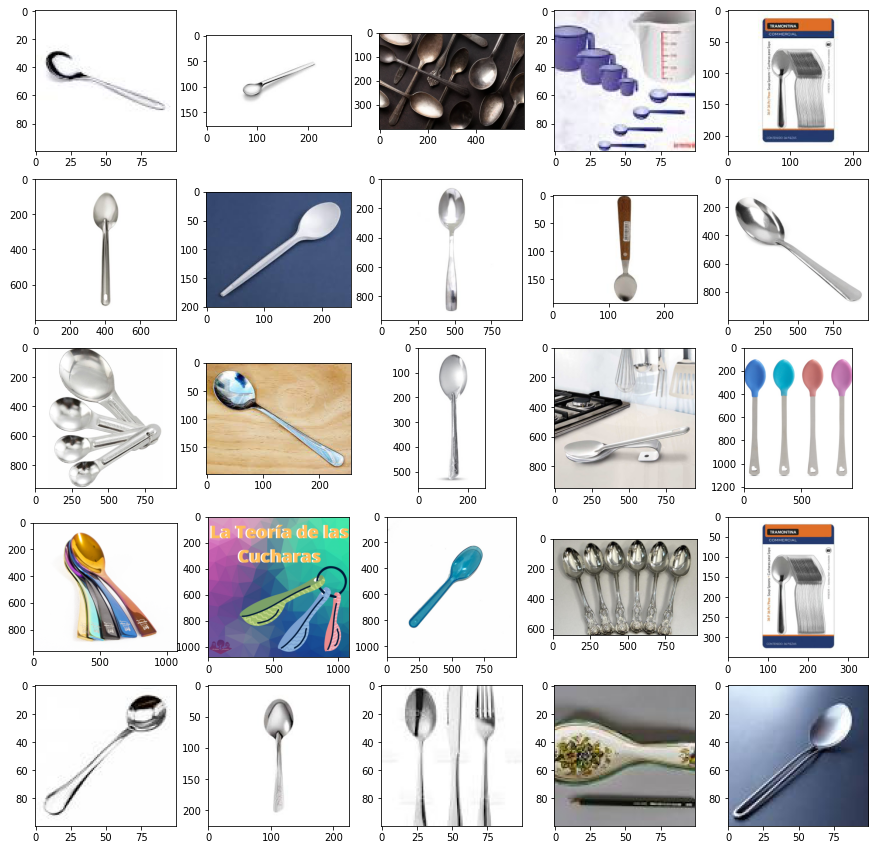

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = '/content/cucharas/cucharas/'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

Creamos la carpeta para el set de datos

In [8]:
!mkdir dataset
!mkdir dataset/cuchillo
!mkdir dataset/tenedor
!mkdir dataset/cuchara

In [11]:
#Copiar imagenes que subimos a carpetas del dataset
#Limitar para que todos tengan la misma cantidad de imagenes

import shutil
carpeta_fuente = '/content/tenedores/tenedores/'
carpeta_destino = '/content/dataset/tenedor/'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 128:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [12]:
#Mostrar cuantas imagenes tengo de cada categoria en el dataset
!ls /content/dataset/cuchara | wc -l
!ls /content/dataset/cuchillo | wc -l
!ls /content/dataset/tenedor | wc -l

128
128
128


Aumento de datos

Found 302 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


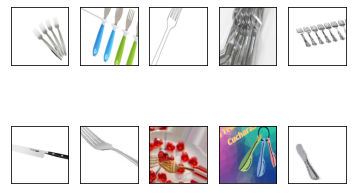

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()

In [14]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

Congelamos modelo 

In [15]:
mobilenetv2.trainable = False

In [16]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(3, activation='softmax')
])

In [17]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


Compilamos

In [18]:
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Entrenamiento del modelo

In [19]:
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/50
10/10 [==============================] - 20s 955ms/step - loss: 1.1625 - accuracy: 0.4305 - val_loss: 0.8075 - val_accuracy: 0.6533
Epoch 2/50
10/10 [==============================] - 8s 781ms/step - loss: 0.7386 - accuracy: 0.6854 - val_loss: 0.5806 - val_accuracy: 0.7867
Epoch 3/50
10/10 [==============================] - 8s 785ms/step - loss: 0.5995 - accuracy: 0.7715 - val_loss: 0.4260 - val_accuracy: 0.8400
Epoch 4/50
10/10 [==============================] - 8s 777ms/step - loss: 0.4340 - accuracy: 0.8377 - val_loss: 0.4355 - val_accuracy: 0.8267
Epoch 5/50
10/10 [==============================] - 8s 910ms/step - loss: 0.4091 - accuracy: 0.8278 - val_loss: 0.4226 - val_accuracy: 0.9067
Epoch 6/50
10/10 [==============================] - 8s 778ms/step - loss: 0.3378 - accuracy: 0.9007 - val_loss: 0.3025 - val_accuracy: 0.9467
Epoch 7/50
10/10 [==============================] - 8s 781ms/step - loss: 0.3324 - accuracy: 0.8940 - val_loss: 0.3621 - val_accuracy: 0.8533
Epoch

Graficas de precision

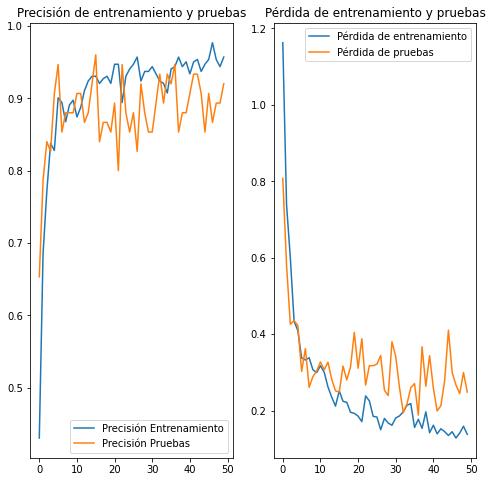

In [20]:
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

Categorizar la imagen

In [21]:
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)


In [31]:
#0 = cuchara
#1 = cuchillo
#2 = tenedor
url = 'https://images-na.ssl-images-amazon.com/images/I/71lFoYGainL._AC_SX466_.jpg' #debe ser 1
prediccion = categorizar (url)
print(prediccion)

1/1 [==============================] - 1s 707ms/step
0


In [ ]:
#Crear la carpeta para exportarla a TF Serving
!mkdir -p carpeta_salida/modelo_cocina/1

In [ ]:
#Guardar el modelo en formato SavedModel
modelo.save('carpeta_salida/modelo_cocina/1')

In [ ]:
#Hacerlo un zip para bajarlo y usarlo en otro lado
!zip -r modelo_cocina.zip /content/carpeta_salida/modelo_cocina/